In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
import pandas as pd
from PIL import Image
import tqdm
from io import BytesIO
import random
from zipfile import ZipFile

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
import tensorflow as tf

import cv2
import kornia 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Creating a model

In [2]:
## Depth Map Model
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1280, decoder_width = .6):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)
        
        self.up0 = UpSample(skip_input=features//1 + 320, output_features=features//2)
        self.up1 = UpSample(skip_input=features//2 + 160, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 64, output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 32, output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 +  24, output_features=features//8)
        self.up5 = UpSample(skip_input=features//8 +  16, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4,x_block5,x_block6 = features[2], features[4], features[6], features[9], features[15],features[18],features[19]
        x_d0 = self.conv2(x_block6)
        x_d1 = self.up0(x_d0, x_block5)
        x_d2 = self.up1(x_d1, x_block4)
        x_d3 = self.up2(x_d2, x_block3)
        x_d4 = self.up3(x_d3, x_block2)
        x_d5 = self.up4(x_d4, x_block1)
        x_d6 = self.up5(x_d5, x_block0)
        return self.conv3(x_d6)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.mobilenet_v2( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Constructing a dataset

In [4]:
def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

In [5]:
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        

        image = self.to_tensor(image)

        depth = depth.resize((320, 240))

        if self.is_test:
            depth = self.to_tensor(depth).float() / 1000
        else:            
            depth = self.to_tensor(depth).float() * 1000
        
        # put in expected range
        depth = torch.clamp(depth, 10, 1000)

        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        pic = np.array(pic)
        if not (_is_numpy_image(pic) or _is_pil_image(pic)):
                raise TypeError(  'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
             
        if isinstance(pic, np.ndarray):
            if pic.ndim==2:
                pic=pic[..., np.newaxis]
                
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)

In [6]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


class DepthDataset(Dataset):
    def __init__(self, traincsv, root_dir, transform=None):
        self.traincsv = traincsv
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.traincsv)

    def __getitem__(self, idx):
        
        sample = self.traincsv[idx]

        img_name = os.path.join(self.root_dir,sample[0])
        image = (Image.open(img_name))
        
        depth_name = os.path.join(self.root_dir,sample[1])
        depth =(Image.open(depth_name))

        sample={'image': image, 'depth': depth}

        if self.transform:  
            sample = self.transform({'image': image, 'depth': depth})
            
        return sample

In [7]:
class Augmentation(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        self.indices = list(permutations(range(3), 3))

    
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(depth)))
        
        # flipping the image
        if random.random() < 0.5:
            #random number generated is less than 0.5 then flip image and depth
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
        
        # rearranging the channels    
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])    

        return {'image': image, 'depth': depth}

Dataset total nums of objects: 50687
0 Image shape: (640, 480) Depth Map shape: (640, 480)


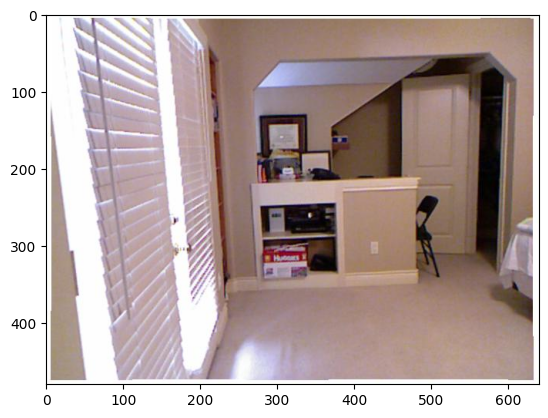

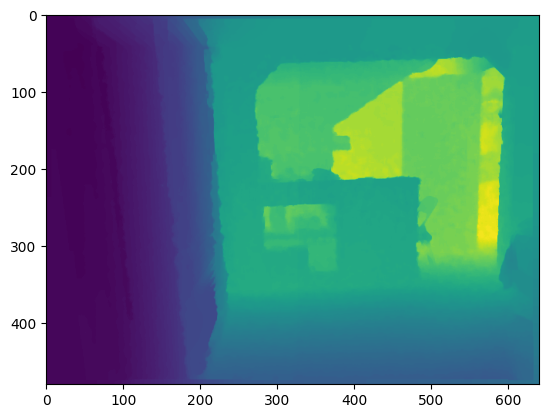

<Figure size 640x480 with 0 Axes>

In [8]:
DATASET_PATH = '/kaggle/input/depth-map-monocular-estimation'

traincsv=pd.read_csv(os.path.join(DATASET_PATH, 'data/nyu2_train.csv'))
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

depth_dataset = DepthDataset(traincsv=traincsv,root_dir=DATASET_PATH)
fig = plt.figure()
print(f"Dataset total nums of objects: {len(depth_dataset)}")
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i,f"Image shape: {sample['image'].size}", f"Depth Map shape: {sample['depth'].size}")
    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()
    if i == 0:
        plt.show()
        break

### Initializing the dataloaders

In [9]:
epochs=10
lr=1e-4
batch_size=4

In [28]:
traincsv = traincsv[:30000]

In [29]:
frac = 0.7
train_slice = traincsv[:int(frac * len(traincsv))]
val_slice = traincsv[int(frac * len(traincsv)):]
print(f"Training objects num: {len(train_slice)}; validation objects num: {len(val_slice)}")

Training objects num: 21000; validation objects num: 9000


In [30]:
train_depth_dataset = DepthDataset(traincsv=train_slice, root_dir=DATASET_PATH,
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(train_depth_dataset, batch_size, shuffle=True)

val_depth_dataset = DepthDataset(traincsv=val_slice, root_dir=DATASET_PATH,
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
val_loader = DataLoader(val_depth_dataset, batch_size, shuffle=False)


In [31]:
len(train_loader), len(val_loader)

(5250, 2250)

### Initializing the losses and optimizer

In [32]:
model = Model()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (encoder): Encoder(
    (original_model): MobileNetV2(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Con

In [33]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIMLoss(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)

In [34]:
l1_criterion = nn.L1Loss()

In [35]:
def grad_loss(image, target):
    x_grad_image = image[...,  1:] - image[..., :-1]
    y_grad_image = image[:, :, :-1, :] - image[:, :, 1:, :]
    
    x_grad_target = target[...,  1:] - target[..., :-1]
    y_grad_target = target[:, :, :-1, :] - target[:, :, 1:, :]
    
    
    return nn.L1Loss()(y_grad_image, y_grad_target) + nn.L1Loss()(x_grad_image, x_grad_target)

In [36]:
optimizer = torch.optim.Adam( model.parameters(), lr )

### Training loop

In [37]:
import wandb
from tqdm.notebook import tqdm

In [22]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [38]:
run = wandb.init(
    # Set the project where this run will be logged
    project="depth-map-training-v4",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

Train/grad_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train/l1_loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train/ssim_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train/total_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train/grad_loss,0.07381
Train/l1_loss,0.90581
Train/ssim_loss,0.01798
Train/total_loss,0.18236


In [41]:
epochs = 10
for epoch in range(epochs):
    N = len(train_loader)
    num_steps = 0

    # Switch to train mode
    model.train()
    
    sum_total_loss = 0
    sum_l1_loss = 0
    sum_ssim_loss = 0
    sum_grad_loss = 0

    for i, sample_batched in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        # Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].to(device))
        depth = torch.autograd.Variable(sample_batched['depth'].to(device))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss

        l_depth = l1_criterion(output, depth_n)
        l_ssim = ssim(output, depth_n, val_range = 1000.0 / 10.0)
        l_grad = grad_loss(output, depth_n)
        

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth) + (1.0 * l_grad)

        # Update step
        loss.backward()
        optimizer.step()
        
        sum_total_loss += loss.detach().item()
        sum_l1_loss += l_depth.detach().item()
        sum_ssim_loss += l_ssim.detach().mean().item()
        sum_grad_loss += l_grad.detach().item()
        
        num_steps +=1
        
        if i % 5 == 0:
            wandb.log({
                "Train/total_loss": sum_total_loss / num_steps,
                "Train/l1_loss": sum_l1_loss / num_steps, 
                "Train/ssim_loss": sum_ssim_loss / num_steps,
                "Train/grad_loss": sum_grad_loss / num_steps
            })
            
            
    
    val_sum_total_loss = 0
    val_sum_l1_loss = 0
    val_sum_ssim_loss = 0
    val_sum_grad_loss = 0
    val_num_steps = 0
    for i, sample_batched in enumerate(val_loader):
        model.eval()
        with torch.no_grad():
             # Prepare sample and target
            image = torch.autograd.Variable(sample_batched['image'].to(device))
            depth = torch.autograd.Variable(sample_batched['depth'].to(device))

            # Normalize depth
            depth_n = DepthNorm( depth )

            # Predict
            output = model(image)

            # Compute the loss
            l_depth = l1_criterion(output, depth_n)
            l_ssim = ssim(output, depth_n, val_range = 1000.0 / 10.0)
            l_grad = grad_loss(output, depth_n)

            loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth) + l_grad
            
            val_sum_total_loss += loss.detach().item()
            val_sum_l1_loss += l_depth.detach().item()
            val_sum_ssim_loss += l_ssim.detach().mean().item()
            val_sum_grad_loss += l_grad.detach().item()
            val_num_steps +=1
            
    wandb.log({
    "Val/total_loss": val_sum_total_loss / val_num_steps, 
    "Val/l1_loss": val_sum_l1_loss / val_num_steps, 
    "Val/ssim_loss": val_sum_ssim_loss / val_num_steps,
    "Val/grad_loss": val_sum_grad_loss / val_num_steps
    })
    
    
    path=f"/kaggle/working/{str(epoch)}.pth"     
    torch.save(model.state_dict(), path)  
    
    


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [42]:
print('ok')

ok
